In [16]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
# import statsmodels.api as sm
import os
import seaborn as sns
sns.set()
from joblib import dump
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D

## BUILDING THE DATASET

In [2]:
#create dataset
data = pd.DataFrame(columns=['scandevice', 'advdevice', 'advdevicerssi', 'distance'])

# Reading gathered data files
files_list = sorted(list(filter(lambda x: ("detectedDevs" in x), os.listdir("/home/aaron/Trabajo/interaction-tracker-updated/PositionTracker/src/Data_Collection/Offline/2moviles/proximity"))))

#concatenate file's data to build the dataset
for file in files_list:
    filename_split = file.split('_')
    distance = float(filename_split[2]) / 100
    df = pd.read_json('/home/aaron/Trabajo/interaction-tracker-updated/PositionTracker/src/Data_Collection/Offline/2moviles/proximity/'+file)

    df.drop(['time'], axis=1, inplace=True)
    df.insert(loc=3, column='distance', value=np.repeat(distance, df.shape[0]))

    data = data.append(df)

data.reset_index(drop=True, inplace=True)

#create the column "dist_<_1m" to allow performing classification
data.insert(4, 'dist_<_1m', data['distance'].apply(lambda dist: 1 if dist < 1.0 else 0))

data.head()

scandevice         advdevice advdevicerssi  distance  dist_<_1m
0  TARGETDEV-r7v5wv  TARGETDEV-z9412b           -57       0.0          1
1  TARGETDEV-r7v5wv  TARGETDEV-z9412b           -58       0.0          1
2  TARGETDEV-r7v5wv  TARGETDEV-z9412b           -57       0.0          1
3  TARGETDEV-r7v5wv  TARGETDEV-z9412b           -57       0.0          1
4  TARGETDEV-r7v5wv  TARGETDEV-z9412b           -57       0.0          1

## PREPROCESSING

In [3]:
data['dist_<_1m'].value_counts()

#imbalanced dataset. down-sample majority class
data_maj = data[data['dist_<_1m'] == 1]
data_min = data[data['dist_<_1m'] == 0]

data_maj_downsampled = resample(data_maj, replace=False, n_samples=data_min.shape[0], random_state=176341)

data = pd.concat([data_maj_downsampled, data_min])
print(data)
print(data['dist_<_1m'].value_counts())

            scandevice         advdevice advdevicerssi  distance  dist_<_1m
854   TARGETDEV-r7v5wv  TARGETDEV-z9412b           -55       0.2          1
1582  TARGETDEV-r7v5wv  TARGETDEV-z9412b           -71       0.6          1
3988  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -72       0.8          1
2853  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -73       0.2          1
2234  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -59       0.0          1
...                ...               ...           ...       ...        ...
3245  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -78       3.0          0
3246  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -79       3.0          0
3247  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -77       3.0          0
3248  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -78       3.0          0
3249  TARGETDEV-z9412b  TARGETDEV-r7v5wv           -78       3.0          0

[3000 rows x 5 columns]
1    1500
0    1500
Name: dist_<_1m, dtype: int64


### VISUALIZE DATA

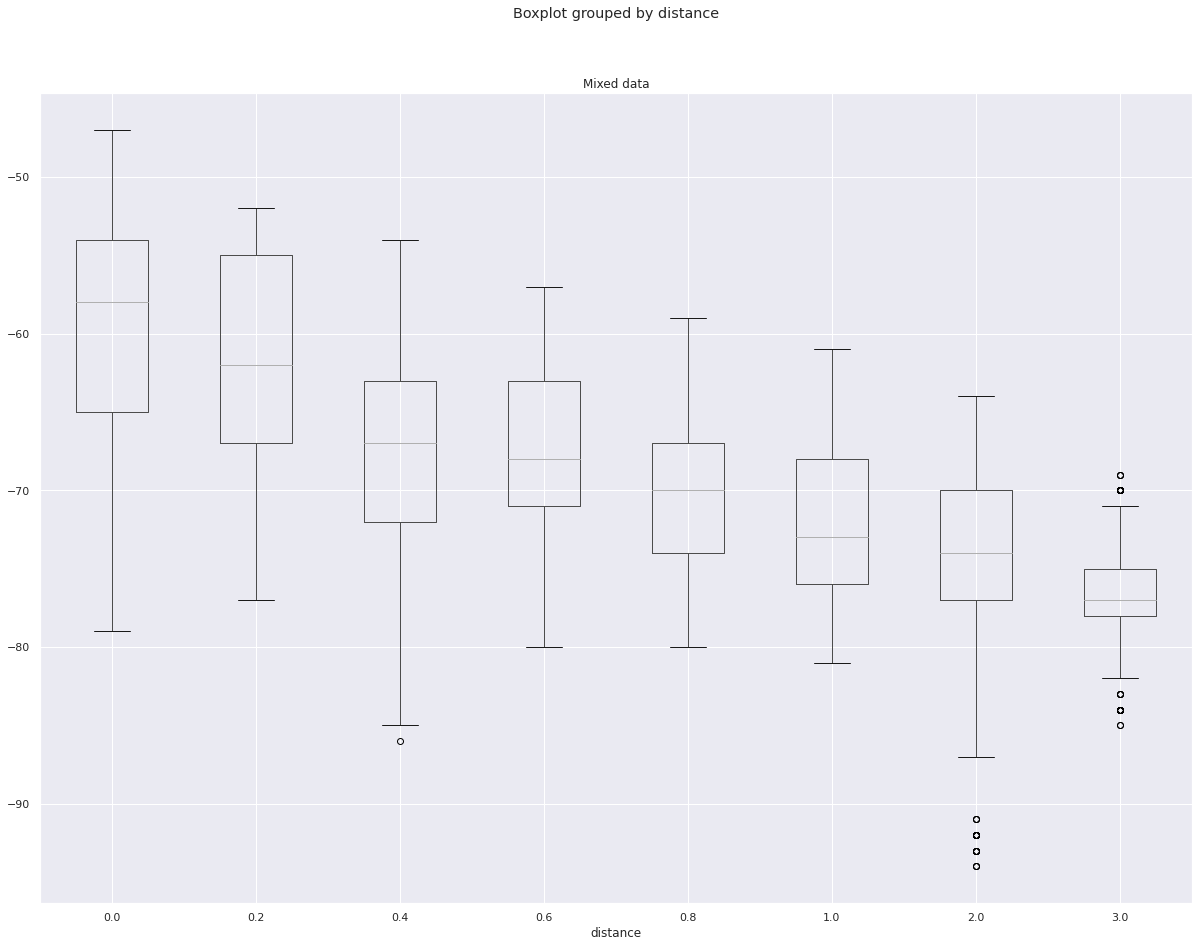

In [4]:
#show boxplot
data['scandevice'].value_counts()

#Mixing data from both mobiles
fig, ax = plt.subplots(figsize=(20,15))
data.boxplot(column='advdevicerssi', by='distance', ax=ax)
ax.set_title("Mixed data")
plt.show()

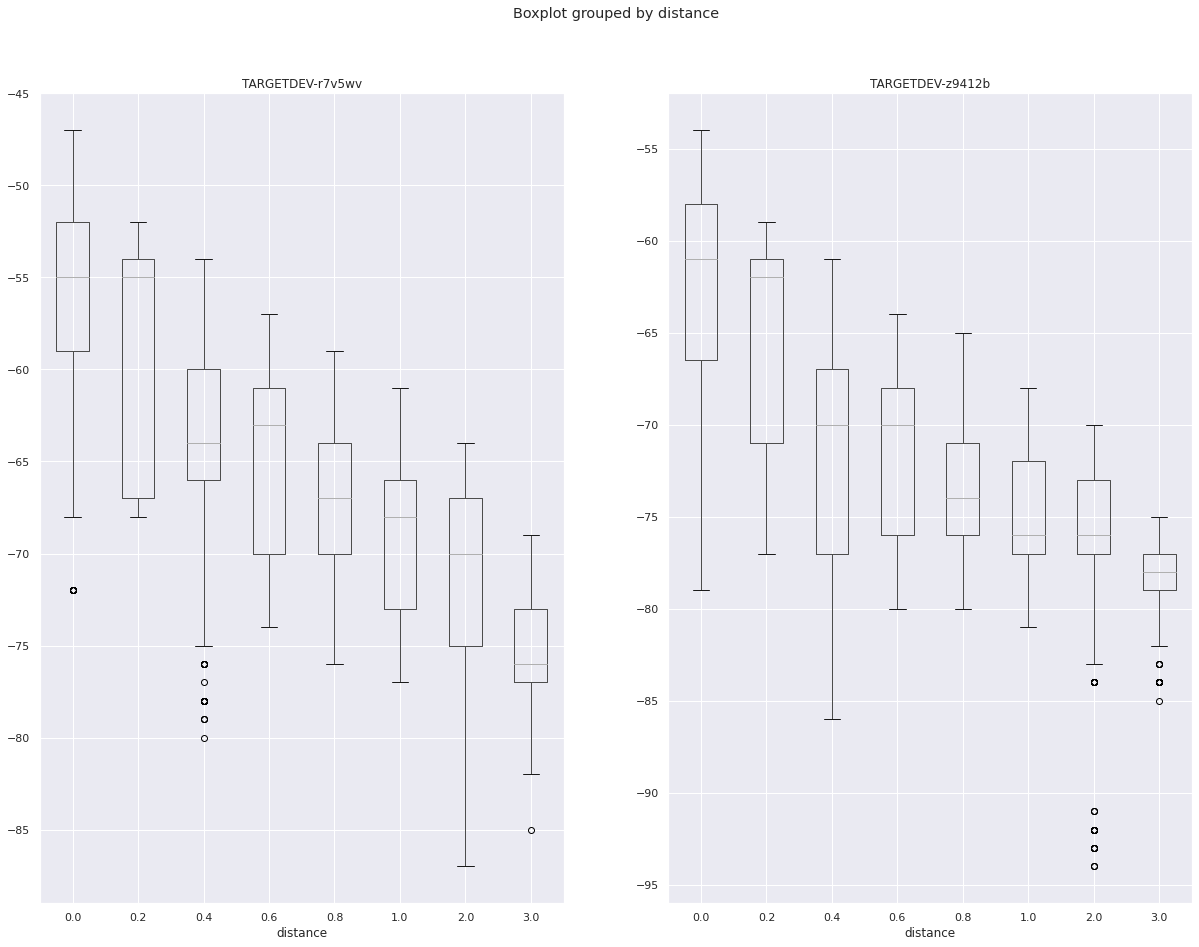

In [5]:
#boxplot for each mobile
fig, ax = plt.subplots(1,2,figsize=(20,15))
anchor_names_list = data['scandevice'].unique()

data[data['scandevice'] == anchor_names_list[0]].boxplot(column='advdevicerssi', by='distance', ax=ax[0])
data[data['scandevice'] == anchor_names_list[1]].boxplot(column='advdevicerssi', by='distance', ax=ax[1])
ax[0].set_title(anchor_names_list[0])
ax[1].set_title(anchor_names_list[1])

plt.show()

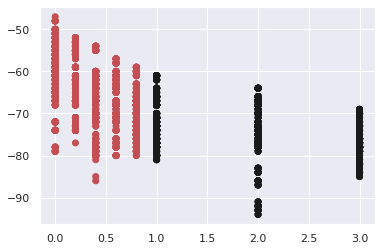

In [6]:
colors_dist = {0: 'k', 1:'r'}

plt.scatter(x=data['distance'], y=data['advdevicerssi'], c=data['dist_<_1m'].apply(lambda x: colors_dist[x]))

### PCA

In [7]:
data_numerical = pd.get_dummies(data, prefix='01' ,columns=['scandevice','advdevice'])
columns = data_numerical.columns.delete(1).delete(1) #delete target variable
print(columns)
data_numerical_standarized = data_numerical.copy()
data_numerical_standarized[columns] = StandardScaler().fit_transform(data_numerical[columns])
data_numerical_standarized

Index(['advdevicerssi', '01_TARGETDEV-r7v5wv', '01_TARGETDEV-z9412b',
       '01_TARGETDEV-r7v5wv', '01_TARGETDEV-z9412b'],
      dtype='object')


advdevicerssi  distance  dist_<_1m  01_TARGETDEV-r7v5wv  \
854        1.865323       0.2          1             1.004678   
1582      -0.148385       0.6          1             1.004678   
3988      -0.274242       0.8          1            -0.995344   
2853      -0.400099       0.2          1            -0.995344   
2234       1.361896       0.0          1            -0.995344   
...             ...       ...        ...                  ...   
3245      -1.029382       3.0          0            -0.995344   
3246      -1.155239       3.0          0            -0.995344   
3247      -0.903526       3.0          0            -0.995344   
3248      -1.029382       3.0          0            -0.995344   
3249      -1.029382       3.0          0            -0.995344   

      01_TARGETDEV-z9412b  01_TARGETDEV-r7v5wv  01_TARGETDEV-z9412b  
854             -1.004678            -1.004678             1.004678  
1582            -1.004678            -1.004678             1.004678  
3988             0.995344             0.995344            -0.995344  
2853             0.995344             0.995344            -0.995344  
2234             0.995344             0.995344            -0.995344  
...                   ...                  ...                  ...  
3245             0.995344             0.995344            -0.995344  
3246             0.995344             0.995344            -0.995344  
3247             0.995344             0.995344            -0.995344  
3248             0.995344             0.995344            -0.995344  
3249             0.995344             0.995344            -0.995344  

[3000 rows x 7 columns]

In [8]:
myPCA = PCA(n_components=3)
myPCA.fit(data_numerical_standarized[columns]);
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[9.05803042e-01 9.41969576e-02 1.44946755e-33]
[0.90580304 1.         1.        ]


In [9]:
transformed_data = myPCA.transform(data_numerical_standarized[columns])
data_numerical_standarized[['PC1','PC2','PC3']] = transformed_data[:,:3]
data_numerical_standarized

advdevicerssi  distance  dist_<_1m  01_TARGETDEV-r7v5wv  \
854        1.865323       0.2          1             1.004678   
1582      -0.148385       0.6          1             1.004678   
3988      -0.274242       0.8          1            -0.995344   
2853      -0.400099       0.2          1            -0.995344   
2234       1.361896       0.0          1            -0.995344   
...             ...       ...        ...                  ...   
3245      -1.029382       3.0          0            -0.995344   
3246      -1.155239       3.0          0            -0.995344   
3247      -0.903526       3.0          0            -0.995344   
3248      -1.029382       3.0          0            -0.995344   
3249      -1.029382       3.0          0            -0.995344   

      01_TARGETDEV-z9412b  01_TARGETDEV-r7v5wv  01_TARGETDEV-z9412b       PC1  \
854             -1.004678            -1.004678             1.004678  3.081172   
1582            -1.004678            -1.004678             1.004678  2.790470   
3988             0.995344             0.995344            -0.995344 -2.825359   
2853             0.995344             0.995344            -0.995344 -2.843527   
2234             0.995344             0.995344            -0.995344 -2.589163   
...                   ...                  ...                  ...       ...   
3245             0.995344             0.995344            -0.995344 -2.934372   
3246             0.995344             0.995344            -0.995344 -2.952541   
3247             0.995344             0.995344            -0.995344 -2.916203   
3248             0.995344             0.995344            -0.995344 -2.934372   
3249             0.995344             0.995344            -0.995344 -2.934372   

           PC2           PC3  
854  -1.435557 -6.783532e-16  
1582  0.557058 -6.783532e-16  
3988 -0.135047  5.426891e-16  
2853 -0.010508  5.426891e-16  
2234 -1.754046  5.426891e-16  
...        ...           ...  
3245  0.612184  5.426891e-16  
3246  0.736722  5.426891e-16  
3247  0.487645  5.426891e-16  
3248  0.612184  5.426891e-16  
3249  0.612184  5.426891e-16  

[3000 rows x 10 columns]

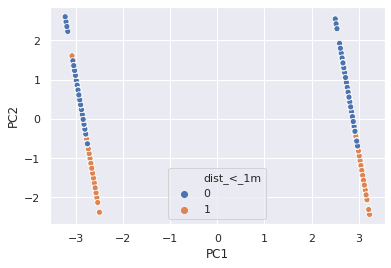

In [10]:
sns.scatterplot(x='PC1', y='PC2', hue='dist_<_1m', data=data_numerical_standarized)

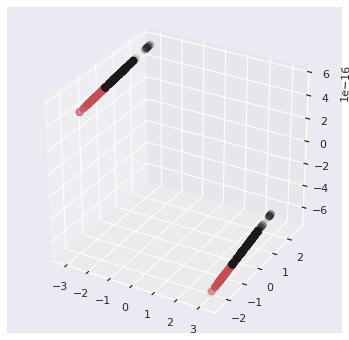

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(data_numerical_standarized.PC1,
            data_numerical_standarized.PC2,
            zs=data_numerical_standarized.PC3,
            depthshade=False,
            alpha=0.1,
            c=data_numerical_standarized['dist_<_1m'].apply(lambda x: colors_dist[x]), s=50)

## USING GAUSSIAN NAIVE BAYES MODEL

### BUILDING TRAIN & TEST SETS

In [29]:
#split in train and test data

train, test = train_test_split(data, test_size=data.shape[0]//3)

### CONVERT CATEGORICAL DATA TO NUMERICAL

In [30]:
#convert categorical data to numerical data
MOVILES = ['TARGETDEV-z9412b', 'TARGETDEV-r7v5wv']
train.replace({'TARGETDEV-z9412b': 0, 'TARGETDEV-r7v5wv': 1}, inplace=True)
test.replace({'TARGETDEV-z9412b': 0, 'TARGETDEV-r7v5wv': 1}, inplace=True)

### APPLY GAUSSIAN NAIVE-BAYES

In [31]:
#apply a gaussian naive-bayes
NB_model = GaussianNB()

NB_model.fit(train.loc[:, 'scandevice':'advdevicerssi'], train['dist_<_1m'])

#using cross validation
NB_model_cv = GaussianNB()
scores = cross_val_score(NB_model_cv, train.loc[:, 'scandevice':'advdevicerssi'], train['dist_<_1m'], cv=10)
print(f'cross validation score: mean->{scores.mean()} std->{scores.std()}\n')

#generate classification report
print("CLASSIFICATION REPORT")
y_test_pred = NB_model.predict(test.loc[:, 'scandevice':'advdevicerssi'])
print(classification_report(y_true=test['dist_<_1m'], y_pred=y_test_pred))

print("----------------------------------------------------------------------------------------------------------")
#print(data.sort_values('RSSI',ascending=False).to_string())

'''
EXPORTING MODEL
'''

dump(NB_model, 'NB_model.joblib')

cross validation score: mean->0.7394999999999999 std->0.03416504061171303

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       519
           1       0.76      0.66      0.71       481

    accuracy                           0.74      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.74      0.74      1000

----------------------------------------------------------------------------------------------------------


['NB_model.joblib']

## USING SVC

### CONVERT CATEGORICAL DATA TO NUMERICAL

In [33]:
data_numerical = pd.get_dummies(data, prefix=['scan_01', 'adv_01'], columns=['scandevice','advdevice'])
data_numerical

advdevicerssi  distance  dist_<_1m  scan_01_TARGETDEV-r7v5wv  \
854            -55       0.2          1                         1   
1582           -71       0.6          1                         1   
3988           -72       0.8          1                         0   
2853           -73       0.2          1                         0   
2234           -59       0.0          1                         0   
...            ...       ...        ...                       ...   
3245           -78       3.0          0                         0   
3246           -79       3.0          0                         0   
3247           -77       3.0          0                         0   
3248           -78       3.0          0                         0   
3249           -78       3.0          0                         0   

      scan_01_TARGETDEV-z9412b  adv_01_TARGETDEV-r7v5wv  \
854                          0                        0   
1582                         0                        0   
3988                         1                        1   
2853                         1                        1   
2234                         1                        1   
...                        ...                      ...   
3245                         1                        1   
3246                         1                        1   
3247                         1                        1   
3248                         1                        1   
3249                         1                        1   

      adv_01_TARGETDEV-z9412b  
854                         1  
1582                        1  
3988                        0  
2853                        0  
2234                        0  
...                       ...  
3245                        0  
3246                        0  
3247                        0  
3248                        0  
3249                        0  

[3000 rows x 7 columns]

### BUILDING TRAIN & TEST SETS

In [45]:
#split in train and test data
X_train, X_test, y_train, y_test = train_test_split(data_numerical.loc[:,['advdevicerssi','scan_01_TARGETDEV-r7v5wv','scan_01_TARGETDEV-z9412b','adv_01_TARGETDEV-r7v5wv' ,'adv_01_TARGETDEV-z9412b']], data_numerical.loc[:,['dist_<_1m']], test_size=data.shape[0]//3)

### SCALE TRAIN & TEST SETS SEPARATELY

In [46]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().transform(X_test)

### APPLY SVC

In [47]:
svc = SVC(class_weight='balanced')

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
Cs = [0.0001, 0.001, 0.1, 0.5, 1, 2, 3, 10, 50 ,100, 1000]

trc = GridSearchCV(estimator=svc,
                   param_grid={
                       'C': Cs,
                       'kernel': kernels
                   },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=10,
                   n_jobs=-1,
                   return_train_score=True,
                   refit='f1_macro')

svc_model_10CV = trc.fit(X_train, y_train)

print(svc_model_10CV.best_score_)
print(svc_model_10CV.best_params_)

0.7614521306869524
{'C': 100, 'kernel': 'rbf'}


In [48]:
pd.DataFrame(svc_model_10CV.cv_results_).loc[:, [
    'mean_fit_time',
    'std_fit_time',
    'param_C',
    'param_kernel',
    'mean_test_accuracy',
    'std_test_accuracy',
    'mean_test_recall_macro',
    'std_test_recall_macro',
    'mean_test_f1_macro',
    'std_test_f1_macro',
]].sort_values(by='mean_test_f1_macro',ascending=False)

mean_fit_time  std_fit_time param_C param_kernel  mean_test_accuracy  \
37       0.188323      0.011240     100          rbf              0.7655   
41       0.806408      0.240602    1000          rbf              0.7625   
21       0.122353      0.030111       2          rbf              0.7645   
25       0.138850      0.046747       3          rbf              0.7635   
33       0.168963      0.031583      50          rbf              0.7625   
17       0.109050      0.009594       1          rbf              0.7620   
13       0.123033      0.019891     0.5          rbf              0.7610   
9        0.112896      0.004580     0.1          rbf              0.7585   
29       0.122372      0.005047      10          rbf              0.7590   
24       0.101129      0.036198       3       linear              0.7545   
14       0.090451      0.006688     0.5         poly              0.7540   
32       0.446806      0.383606      50       linear              0.7535   
36       0.448935      0.199067     100       linear              0.7535   
30       0.110169      0.006860      10         poly              0.7535   
20       0.073370      0.004378       2       linear              0.7535   
26       0.102954      0.016780       3         poly              0.7535   
38       0.226195      0.035133     100         poly              0.7535   
22       0.143025      0.044386       2         poly              0.7535   
34       0.181949      0.017462      50         poly              0.7535   
40       3.150005      1.099364    1000       linear              0.7535   
42       0.941158      0.263632    1000         poly              0.7535   
16       0.066878      0.002318       1       linear              0.7530   
18       0.104285      0.024938       1         poly              0.7530   
12       0.073929      0.005404     0.5       linear              0.7530   
28       0.130068      0.017174      10       linear              0.7520   
8        0.068516      0.001511     0.1       linear              0.7500   
10       0.083968      0.001770     0.1         poly              0.7450   
11       0.232549      0.024192     0.1      sigmoid              0.7400   
4        0.106016      0.015676   0.001       linear              0.7440   
15       0.172139      0.006278     0.5      sigmoid              0.7325   
6        0.121048      0.003094   0.001         poly              0.7170   
19       0.164775      0.003777       1      sigmoid              0.7040   
23       0.236158      0.066514       2      sigmoid              0.6880   
39       0.139667      0.004929     100      sigmoid              0.6875   
35       0.143937      0.011299      50      sigmoid              0.6875   
43       0.127164      0.007232    1000      sigmoid              0.6875   
31       0.144886      0.005579      10      sigmoid              0.6870   
27       0.155363      0.003546       3      sigmoid              0.6870   
7        0.284736      0.001616   0.001      sigmoid              0.5050   
5        0.163788      0.003831   0.001          rbf              0.5050   
1        0.166833      0.002290  0.0001          rbf              0.4950   
3        0.287883      0.003435  0.0001      sigmoid              0.4950   
2        0.128268      0.006533  0.0001         poly              0.4950   
0        0.142409      0.047947  0.0001       linear              0.4950   

    std_test_accuracy  mean_test_recall_macro  std_test_recall_macro  \
37           0.026875                0.766792               0.026663   
41           0.033185                0.763561               0.033146   
21           0.036156                0.765942               0.035922   
25           0.035570                0.764941               0.035344   
33           0.029602                0.763851               0.029373   
17           0.034655                0.763476               0.034462   
13           0.034843                0.762476               0.034640   
9      

## Using Multi Layer Perceptron (MLP)

### CONVERT CATEGORICAL DATA TO NUMERICAL

In [12]:
data_numerical = pd.get_dummies(data, prefix=['scan_01', 'adv_01'], columns=['scandevice','advdevice'])
data_numerical

advdevicerssi  distance  dist_<_1m  scan_01_TARGETDEV-r7v5wv  \
854            -55       0.2          1                         1   
1582           -71       0.6          1                         1   
3988           -72       0.8          1                         0   
2853           -73       0.2          1                         0   
2234           -59       0.0          1                         0   
...            ...       ...        ...                       ...   
3245           -78       3.0          0                         0   
3246           -79       3.0          0                         0   
3247           -77       3.0          0                         0   
3248           -78       3.0          0                         0   
3249           -78       3.0          0                         0   

      scan_01_TARGETDEV-z9412b  adv_01_TARGETDEV-r7v5wv  \
854                          0                        0   
1582                         0                        0   
3988                         1                        1   
2853                         1                        1   
2234                         1                        1   
...                        ...                      ...   
3245                         1                        1   
3246                         1                        1   
3247                         1                        1   
3248                         1                        1   
3249                         1                        1   

      adv_01_TARGETDEV-z9412b  
854                         1  
1582                        1  
3988                        0  
2853                        0  
2234                        0  
...                       ...  
3245                        0  
3246                        0  
3247                        0  
3248                        0  
3249                        0  

[3000 rows x 7 columns]

### BUILDING TRAIN & TEST SETS

In [13]:
#split in train and test data
X_train, X_test, y_train, y_test = train_test_split(data_numerical.loc[:,['advdevicerssi','scan_01_TARGETDEV-r7v5wv','scan_01_TARGETDEV-z9412b','adv_01_TARGETDEV-r7v5wv' ,'adv_01_TARGETDEV-z9412b']], data_numerical.loc[:,['dist_<_1m']], test_size=data.shape[0]//3)

### SCALE TRAIN & TEST SETS SEPARATELY

In [14]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().transform(X_test)

### APPLY MLP

In [28]:
sizes = [2*i for i in range(1,4)]
sizes = sizes + [[2*i,2*i] for i in range(1,6)]
sizes = sizes + [[2*i, 2*i, 2*i] for i in range (1,6)]

alphas = [0, 0.1, 0.01, 0.001]

activations = ['logistic', 'relu', 'tanh']

In [29]:
model_nnet = MLPClassifier(max_iter=500, solver='lbfgs',random_state=42)

trc = GridSearchCV(estimator=model_nnet, 
                   param_grid ={'hidden_layer_sizes': sizes,
                                'alpha': alphas,
                                'activation': activations},
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=10,
                   n_jobs=-1,
                   return_train_score=True,
                   refit='f1_macro')

mlp_model_10CV = trc.fit(X_train,y_train)
mlp_model_10CV.best_score_
mlp_model_10CV.best_params_

{'activation': 'logistic', 'alpha': 0, 'hidden_layer_sizes': [10, 10]}

In [30]:
pd.DataFrame(mlp_model_10CV.cv_results_).loc[:, [
    'mean_fit_time',
    'std_fit_time',
    'param_activation',
    'param_hidden_layer_sizes',
    'param_alpha',
    'mean_test_accuracy',
    'std_test_accuracy',
    'mean_test_recall_macro',
    'std_test_recall_macro',
    'mean_test_f1_macro',
    'std_test_f1_macro',
]].sort_values(by='mean_test_f1_macro',ascending=False)

mean_fit_time  std_fit_time param_activation param_hidden_layer_sizes  \
7         1.436946      0.509806         logistic                 [10, 10]   
128       4.040006      0.468635             tanh                [8, 8, 8]   
149       3.276060      0.632814             tanh                   [8, 8]   
31        2.028014      0.383666         logistic                   [6, 6]   
111       2.394948      0.268531             tanh                 [10, 10]   
..             ...           ...              ...                      ...   
74        0.035893      0.016058             relu                [4, 4, 4]   
86        0.015752      0.003890             relu                [2, 2, 2]   
87        0.035099      0.010388             relu                [4, 4, 4]   
99        0.013566      0.005819             relu                [2, 2, 2]   
100       0.017217      0.000279             relu                [4, 4, 4]   

    param_alpha  mean_test_accuracy  std_test_accuracy  \
7             0              0.7790           0.027641   
128         0.1              0.7780           0.026665   
149       0.001              0.7785           0.023564   
31         0.01              0.7775           0.030842   
111           0              0.7775           0.027318   
..          ...                 ...                ...   
74          0.1              0.5070           0.002449   
86         0.01              0.5070           0.002449   
87         0.01              0.5070           0.002449   
99        0.001              0.5070           0.002449   
100       0.001              0.5070           0.002449   

     mean_test_recall_macro  std_test_recall_macro  mean_test_f1_macro  \
7                  0.779812               0.027765            0.778478   
128                0.778278               0.026857            0.777692   
149                0.779152               0.023587            0.777568   
31                 0.777468               0.030937            0.777285   
111                0.778078               0.027445            0.777058   
..                      ...                    ...                 ...   
74                 0.500000               0.000000            0.336428   
86                 0.500000               0.000000            0.336428   
87                 0.500000               0.000000            0.336428   
99                 0.500000               0.000000            0.336428   
100                0.500000               0.000000            0.336428   

     std_test_f1_macro  
7             0.027646  
128           0.026695  
149           0.023691  
31            0.030893  
111           0.027275  
..                 ...  
74            0.001078  
86            0.001078  
87            0.001078  
99            0.001078  
100           0.001078  

[156 rows x 11 columns]

### RE-TRAIN WITH TEST DATA USING THE BEST MODEL

In [50]:
svm = SVC(C=100, kernel='rbf' ,class_weight='balanced')
svm.fit(X_train,y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       510
           1       0.85      0.70      0.77       490

    accuracy                           0.79      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000

